In [33]:
import read_in_data as rd
import pandas as pd
import numpy as np
import os
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV
from sklearn.metrics import mean_squared_error

In [3]:
cities_PM2point5 = rd.read_in_NASA_data('/Users/josephmacula/umn_bootcamp/umn_bootcamp_capstone_project/NASA_data/nasa_data/PM_2point5_data/surface_density_hourly')
aqicn_data = rd.read_in_aqicn_data('/Users/josephmacula/umn_bootcamp/umn_bootcamp_capstone_project/aqicn_data')

/Users/josephmacula/umn_bootcamp/capstone_project/read_in_data.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aqicn_data[name]['date'] = pd.to_datetime(aqicn_data[name]['date'])
/Users/josephmacula/umn_bootcamp/capstone_project/read_in_data.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aqicn_data[name]['date'] = pd.to_datetime(aqicn_data[name]['date'])
/Users/josephmacula/umn_bootcamp/capstone_project/read_in_data.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aqicn_data[name]['date'] = pd.to_datetime(aqicn_data[name]['date'])


In [24]:
merged_data = []
for i in list(cities_PM2point5.keys()):
    if i.lower() in aqicn_data.keys():
        combined_df = cities_PM2point5[i.capitalize()].merge(aqicn_data[i.lower()], how = 'left', left_on = 'day', right_on = 'date')
        merged_data.append(combined_df)

for i in range(0, len(merged_data)):
    merged_data[i]['converted_NASA_concentrations'] = merged_data[i].iloc[:,1].apply(lambda x: round(rd.concentration_to_AQI(x)))
    merged_data[i] = merged_data[i].dropna()
    merged_data[i] = merged_data[i][merged_data[i][' pm25'] != ' ']
    merged_data[i][' pm25'] = pd.to_numeric(merged_data[i][' pm25'])

In [38]:
shanghai_data = merged_data[8][['date',' pm25', 'converted_NASA_concentrations']]
shanghai_data_monthly = shanghai_data.groupby(shanghai_data['date'].dt.to_period('M'))[[' pm25', 'converted_NASA_concentrations']].mean().reset_index()

aqicn_monthly = shanghai_data_monthly[' pm25']
aqicn_monthly.index = shanghai_data_monthly['date']
start_period_aqicn = aqicn_monthly.index.min()
end_period_aqicn = aqicn_monthly.index.max()
period_range_aqicn = pd.period_range(start=start_period_aqicn, end=end_period_aqicn, freq='M')
reindexed_aqicn_monthly = aqicn_monthly.reindex(period_range_aqicn)
reindexed_aqicn_monthly = reindexed_aqicn_monthly.interpolate(method='linear')

reindexed_aqicn_monthly.index = reindexed_aqicn_monthly.index.to_timestamp()

nasa_monthly = shanghai_data_monthly['converted_NASA_concentrations']
nasa_monthly.index = shanghai_data_monthly['date']
start_period_nasa = nasa_monthly.index.min()
end_period_nasa = nasa_monthly.index.max()
period_range_nasa = pd.period_range(start = start_period_nasa, end = end_period_nasa, freq='M')
reindexed_nasa_monthly = nasa_monthly.reindex(period_range_nasa)
reindexed_nasa_monthly = reindexed_nasa_monthly.interpolate(method = 'linear')

reindexed_nasa_monthly.index = reindexed_nasa_monthly.index.to_timestamp()


In [39]:
aqicn_train_data, aqicn_test_data = model_selection.train_test_split(reindexed_aqicn_monthly, train_size = 0.7)
aqicn_arima = pm.auto_arima(aqicn_train_data, seasonal = True, m = 12)

In [40]:
nasa_train_data, nasa_test_data = model_selection.train_test_split(reindexed_nasa_monthly, train_size = 0.7)
nasa_arima = pm.auto_arima(nasa_train_data, seasonal = True, m = 12)

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

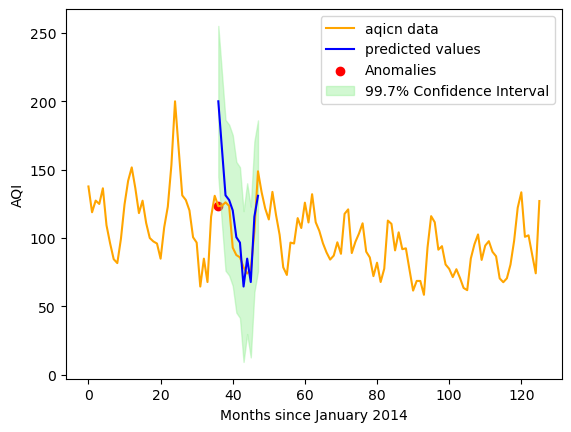

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

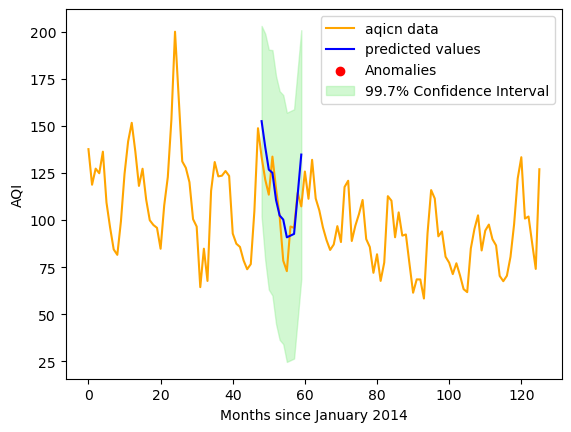

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

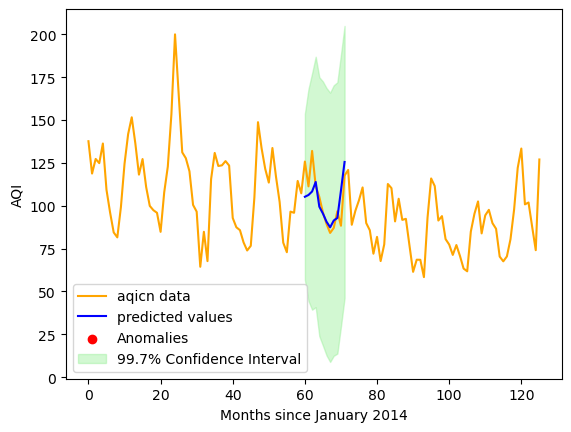

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

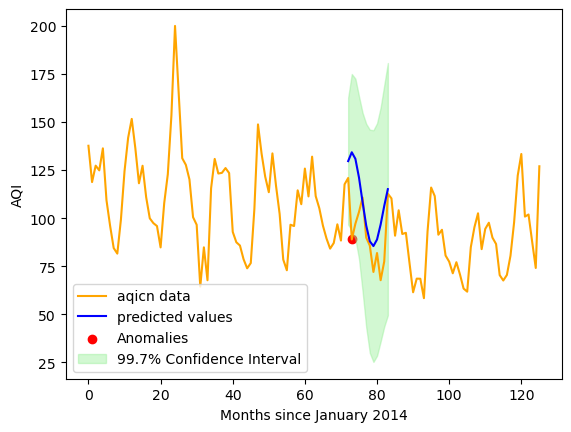

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

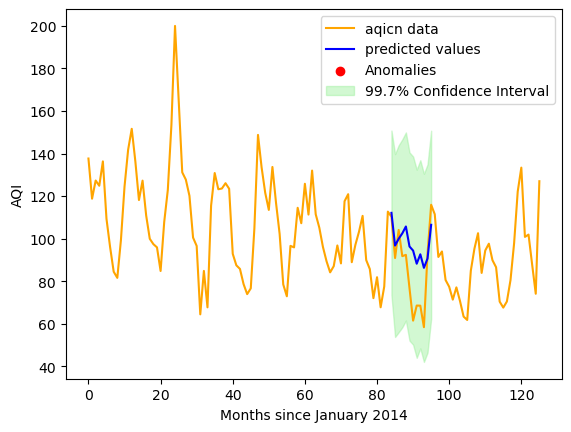

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

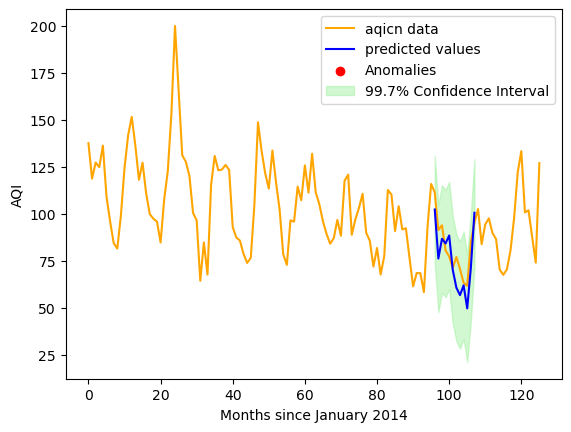

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_18024/3916505608.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 

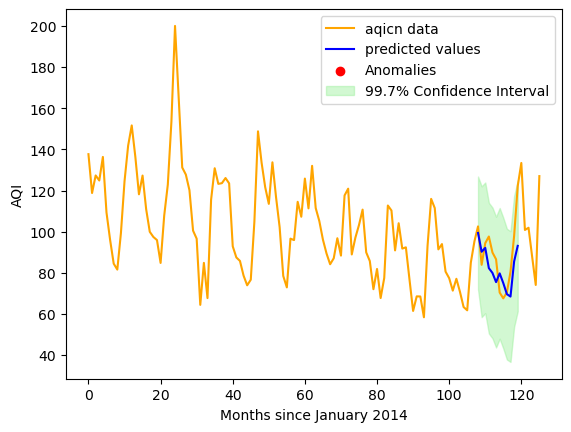

In [44]:
cv_aqicn = model_selection.SlidingWindowForecastCV(window_size = 36, step = 12, h = 12)
cv_generator = cv_aqicn.split(reindexed_aqicn_monthly)

for i in cv_generator:
    model = pm.auto_arima(reindexed_aqicn_monthly[i[0]], seasonal = True, m = 12)
    forecast, conf_int = model.predict(i[1].shape[0], return_conf_int = True, alpha = .003)
    anamoly_indicator = (reindexed_aqicn_monthly[i[1]] < conf_int[:, 0]) | (reindexed_aqicn_monthly[i[1]] > conf_int[:, 1])
    anomaly_timestamps = reindexed_aqicn_monthly[i[1]].index[anamoly_indicator]
    anomaly_array_indices = reindexed_aqicn_monthly.index.get_indexer(anomaly_timestamps)
    x = np.arange(reindexed_aqicn_monthly.shape[0])
    plt.plot(x, reindexed_aqicn_monthly, c = 'orange', label = 'aqicn data')
    plt.plot(x[i[1]], forecast, c = 'blue', label = 'predicted values')
    plt.scatter(anomaly_array_indices, reindexed_aqicn_monthly.iloc[anomaly_array_indices], color='red', label='Anomalies')
    plt.fill_between(x[i[1]], conf_int[:, 0], conf_int[:, 1], color='lightgreen', alpha=0.4, label="99.7% Confidence Interval")
    plt.ylabel('AQI')
    plt.xlabel('Months since January 2014')
    plt.legend()
    plt.show()


In [45]:
aqicn_arima = pm.auto_arima(reindexed_aqicn_monthly, seasonal = True, m = 12)
nasa_arima = pm.auto_arima(reindexed_nasa_monthly, seasonal = True, m = 12)

In [47]:
aqicn_arima_forecasts, aqicn_conf_int = aqicn_arima.predict(n_periods=24, return_conf_int=True, alpha = .003) 
nasa_arima_forecasts, nasa_conf_int = nasa_arima.predict(n_periods=24, return_conf_int = True, alpha = .003)

In [48]:
forecast_index = pd.date_range(start=reindexed_aqicn_monthly.index[-1] + pd.offsets.MonthBegin(), periods=24, freq='MS')

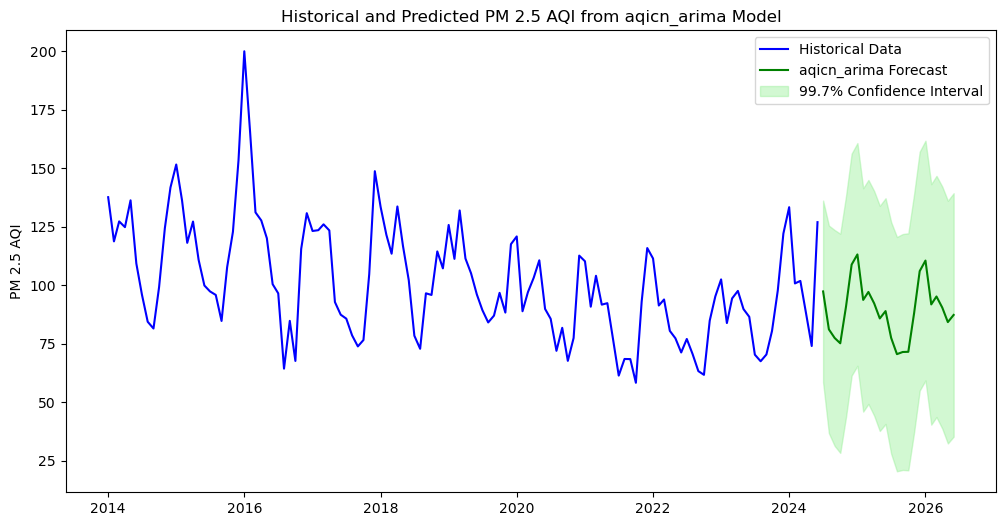

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(reindexed_aqicn_monthly, label="Historical Data", color="blue")
plt.plot(forecast_index, aqicn_arima_forecasts, label="aqicn_arima Forecast", color="green")
plt.fill_between(forecast_index,
                 aqicn_conf_int[:, 0], aqicn_conf_int[:, 1],
                 color='lightgreen', alpha=0.4, label="99.7% Confidence Interval")
plt.ylabel('PM 2.5 AQI')
plt.legend()
plt.title('Historical and Predicted PM 2.5 AQI from aqicn_arima Model')
plt.show()

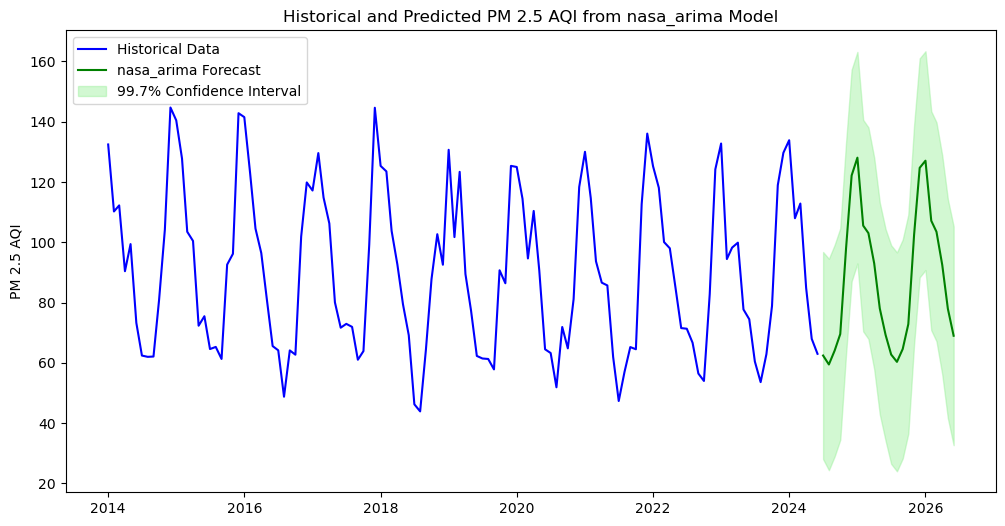

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(reindexed_nasa_monthly, label="Historical Data", color="blue")
plt.plot(forecast_index, nasa_arima_forecasts, label="nasa_arima Forecast", color="green")
plt.fill_between(forecast_index,
                 nasa_conf_int[:, 0], nasa_conf_int[:, 1],
                 color='lightgreen', alpha=0.4, label="99.7% Confidence Interval")
plt.ylabel('PM 2.5 AQI')
plt.legend()
plt.title('Historical and Predicted PM 2.5 AQI from nasa_arima Model')
plt.show()

In [52]:
shanghai_data = merged_data[8][['date',' pm25', 'converted_NASA_concentrations']]
shanghai_data_weekly = shanghai_data.groupby(shanghai_data['date'].dt.to_period('W'))[[' pm25', 'converted_NASA_concentrations']].mean().reset_index()


In [53]:
aqicn_weekly = shanghai_data_weekly[' pm25']
aqicn_weekly.index = shanghai_data_weekly['date']
start_period_aqicn = aqicn_weekly.index.min()
end_period_aqicn = aqicn_weekly.index.max()
period_range_aqicn = pd.period_range(start=start_period_aqicn, end=end_period_aqicn, freq='W')
reindexed_aqicn_weekly = aqicn_weekly.reindex(period_range_aqicn)
reindexed_aqicn_weekly = reindexed_aqicn_weekly.interpolate(method='linear')

reindexed_aqicn_weekly.index = reindexed_aqicn_weekly.index.to_timestamp()

nasa_weekly = shanghai_data_weekly['converted_NASA_concentrations']
nasa_weekly.index = shanghai_data_weekly['date']
start_period_nasa = nasa_weekly.index.min()
end_period_nasa = nasa_weekly.index.max()
period_range_nasa = pd.period_range(start = start_period_nasa, end = end_period_nasa, freq='W')
reindexed_nasa_weekly = nasa_weekly.reindex(period_range_nasa)
reindexed_nasa_weekly = reindexed_nasa_weekly.interpolate(method = 'linear')

reindexed_nasa_weekly.index = reindexed_nasa_weekly.index.to_timestamp()

In [54]:
aqicn_train_data_weekly, aqicn_test_data_weekly = model_selection.train_test_split(reindexed_aqicn_weekly, train_size = 0.7)
aqicn_arima_weekly = pm.auto_arima(aqicn_train_data_weekly, seasonal = True, m = 12)

In [57]:
aqicn_arima_weekly

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [58]:
nasa_train_data_weekly, nasa_test_data_weekly = model_selection.train_test_split(reindexed_nasa_weekly, train_size = 0.7)
nasa_arima_weekly = pm.auto_arima(nasa_train_data_weekly, seasonal = True, m = 12)

In [59]:
nasa_arima_weekly

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)